In [57]:
using RelDist
using SintPowerGraphs
using DataFrames
using Plots

using TikzGraphs
using TikzPictures
using Graphs
using Printf
using MetaGraphs
using LaTeXStrings

network_filename = joinpath(@__DIR__, "CINELDI.toml")
interruption_filename = joinpath(@__DIR__, "../../databases/interruption_FASIT2.json")
cost_filename = joinpath(@__DIR__, "../../databases/cost_functions_dummy.json")

interruption = read_interruption(interruption_filename)
cost_functions = read_cost_functions(cost_filename)

network = RadialPowerGraph(network_filename)

I don't know switch status.
All switches will be assumed closed.
I don't know if switch or circuit breaker.
All switchgear will be assumed to be switches.


RadialPowerGraph({124, 123} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), SintPowerCase.Case(100.0, 124×13 DataFrame
 Row │ ID      type   Pd         Qd         Gs     Bs     bus_area  Vm         ⋯
     │ String  Int64  Float64    Float64    Int64  Int64  Int64     Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1           3  0.0        0.0            0      0         0  1.0        ⋯
   2 │ 10          1  0.0774794  0.0254652      0      0         0  0.992941
   3 │ 100         1  0.0        0.0            0      0         0  0.953577
   4 │ 101         1  0.186032   0.0611432      0      0         0  0.953577
   5 │ 102         1  0.0        0.0            0      0         0  0.954258   ⋯
   6 │ 103         1  0.295512   0.0971259      0      0         0  0.954216
   7 │ 104         1  0.0        0.0            0      0         0  0.954178
   8 │ 105         1  0.296369   0.0974076      0   

In [58]:
# The names in the CINELDI dataframe are not the same as what is expected.
rename!(network.mpc.reldata, :r_perm => :repairTime)
rename!(network.mpc.reldata, :r_temp => :temporaryFaultTime)
rename!(network.mpc.reldata, :lambda_perm => :permanentFaultFrequency)
rename!(network.mpc.reldata, :lambda_temp => :temporaryFaultFrequency)

rename!(network.mpc.reldata, :sectioning_time => :sectioningTime)
network.mpc.branch[!, :ID] = [string("l", l) for l in 1:length(network.mpc.branch.f_bus)]

123-element Vector{String}:
 "l1"
 "l2"
 "l3"
 "l4"
 "l5"
 "l6"
 "l7"
 "l8"
 "l9"
 "l10"
 "l11"
 "l12"
 "l13"
 ⋮
 "l112"
 "l113"
 "l114"
 "l115"
 "l116"
 "l117"
 "l118"
 "l119"
 "l120"
 "l121"
 "l122"
 "l123"

In [3]:
function create_node_labels(network, load_agg, var)
    load_nodes = network.mpc.load.bus
    node_styles = Dict()
    node_labels = Array{String, 1}(undef, nv(network.radial))
    graph_df = load_agg[!, [:ID, var]]
    max_val, _ = findmax(load_agg[!, var])
    for node in vertices(network.radial)
        node_name = get_prop(network.radial, node, :name)
        if (node_name in load_nodes)
            node_labels[node] =  L"\bigtriangledown" #@sprintf("%5.2f", load_cens[node])
            red = graph_df[graph_df.ID .== network.mpc.load[network.mpc.load.bus.==node_name, "ID"], end][1]/max_val*100
            node_styles[node] = @sprintf("red!%1.0f!green, font=\\small", red)
        elseif node_name == network.ref_bus
            node_labels[node] =  "Feeder"
            node_styles[node] = "draw,fill=blue!10,font=\\tiny"
        elseif node_name ∈ network.reserves
            node_labels[node] =  "BF"
        else 
            node_labels[node] = "."
         end
    end
    return node_styles, node_labels
end

create_node_labels (generic function with 1 method)

In [4]:
function create_edge_labels(network, branch_agg, var)
    edge_colors = Dict()
    edge_labels = Dict()
    max_val, _ = findmax(branch_agg[!, var])
    for edge in edges(network.radial)
        branch = get_branch_data(network, get_prop(network.radial, src(edge), :name),
        get_prop(network.radial, dst(edge), :name))
        f_bus = branch.f_bus
        t_bus = branch.t_bus
        name = edge_pos[edge_pos.f_bus .== f_bus .&& edge_pos.t_bus .== t_bus, :name]
        cost = branch_agg[branch_agg.ID .== name, "ENS"][1]
        red = cost/max_val*100
        edge_colors[(src(edge), dst(edge))] = @sprintf("red!%1.0f!green, font=\\bold", red)
    end
    return edge_colors, edge_labels
end

create_edge_labels (generic function with 1 method)

In [5]:
function sorted_bar_plot(df, var, n, title, ylabel)
    df = first(sort(df, [var], rev=true), n)
    return bar(df[:, var],
        xticks=(1:n, df[:, "ID"]),
        legend=false, title=title, ylabel=ylabel)
end

sorted_bar_plot (generic function with 1 method)

## Results no reserve
Here I calculate the results with no reserve connections.

In [6]:
res, rest, L, edge_pos = relrad_calc(interruption, cost_functions, network)

┌ Warning: load dataframe found, but no load found, attemping to use bus dataframe
└ @ RelDist ~/.julia/dev/RelDist.jl/src/load.jl:20
[ Info: Processing line RelDist.Branch{String}("1", "2")
[ Info: Processing line RelDist.Branch{String}("2", "3")
[ Info: Processing line RelDist.Branch{String}("3", "4")
[ Info: Processing line RelDist.Branch{String}("4", "5")
[ Info: Processing line RelDist.Branch{String}("5", "7")
[ Info: Processing line RelDist.Branch{String}("7", "10")
[ Info: Processing line RelDist.Branch{String}("7", "11")
[ Info: Processing line RelDist.Branch{String}("7", "9")
[ Info: Processing line RelDist.Branch{String}("9", "12")
[ Info: Processing line RelDist.Branch{String}("12", "16")
[ Info: Processing line RelDist.Branch{String}("16", "17")
[ Info: Processing line RelDist.Branch{String}("16", "18")
[ Info: Processing line RelDist.Branch{String}("18", "19")
[ Info: Processing line RelDist.Branch{String}("19", "20")
[ Info: Processing line RelDist.Branch{String}("19", "2

(RelStruct([5.0 5.0 … 0.5 5.0; 5.0 5.0 … 5.0 5.0; … ; 5.0 5.0 … 5.0 5.0; 5.0 5.0 … 5.0 5.0], [0.057584246156799995 0.0357828165728 … 0.00170124687392 2.09659115806746e-5; 0.057584246156799995 0.0357828165728 … 0.0170124687392 2.09659115806746e-5; … ; 0.057584246156799995 0.0357828165728 … 0.0170124687392 2.09659115806746e-5; 0.057584246156799995 0.0357828165728 … 0.0170124687392 2.09659115806746e-5], [0.004461593302355139 0.0027724314446331325 … 0.00013181160065317224 1.6244264174510123e-6; 0.010712521464184218 0.006656754514790515 … 0.0031648662384359777 3.900333733858264e-6; … ; 0.010583329307651313 0.006576474584976491 … 0.0031266982034081144 3.853296019351938e-6; 0.004732946624171889 0.002941050238644073 … 0.0013982835907719545 1.7232237471380398e-6], [0.004461593302355139 0.0027724314446331325 … 0.00013181160065317224 1.6244264174510123e-6; 0.010712521464184218 0.006656754514790515 … 0.0031648662384359777 3.900333733858265e-6; … ; 0.010583329307651313 0.006576474584976491 … 0.0031

In [7]:
res_agg = ResFrames(res, rest, edge_pos, L) # Aggregate results for processing

ResFrames(54×124 DataFrame
 Row │ L       l1         l2         l3         l4         l5       l6         ⋯
     │ String  Float64    Float64    Float64    Float64    Float64  Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ L4      0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367  ⋯
   2 │ L41     0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367
   3 │ L42     0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367
   4 │ L43     0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367
   5 │ L44     0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367  ⋯
   6 │ L45     0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367
   7 │ L46     0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367
   8 │ L5      0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367
   9 │ L47     0.0576061  0.0357964  0.0659177  0.0171938  0.04167  0.0234367  ⋯
  10 │ L48     0.05

## Results reserve connection at bus 62
Here I calculate the results with a reserve connection at bus 62.

In [8]:
network.reserves = ["62"]

1-element Vector{String}:
 "62"

In [9]:
res_62, rest_62, L, edge_pos = relrad_calc(interruption, cost_functions, network)

┌ Warning: load dataframe found, but no load found, attemping to use bus dataframe
└ @ RelDist ~/.julia/dev/RelDist.jl/src/load.jl:20
[ Info: Processing line RelDist.Branch{String}("1", "2")
[ Info: Processing line RelDist.Branch{String}("2", "3")
[ Info: Processing line RelDist.Branch{String}("3", "4")
[ Info: Processing line RelDist.Branch{String}("4", "5")
[ Info: Processing line RelDist.Branch{String}("5", "7")
[ Info: Processing line RelDist.Branch{String}("7", "10")
[ Info: Processing line RelDist.Branch{String}("7", "11")
[ Info: Processing line RelDist.Branch{String}("7", "9")
[ Info: Processing line RelDist.Branch{String}("9", "12")
[ Info: Processing line RelDist.Branch{String}("12", "16")
[ Info: Processing line RelDist.Branch{String}("16", "17")
[ Info: Processing line RelDist.Branch{String}("16", "18")
[ Info: Processing line RelDist.Branch{String}("18", "19")
[ Info: Processing line RelDist.Branch{String}("19", "20")
[ Info: Processing line RelDist.Branch{String}("19", "2

(RelStruct([0.5 0.5 … 0.5 5.0; 0.5 0.5 … 5.0 0.5; … ; 0.5 0.5 … 5.0 0.5; 0.5 0.5 … 5.0 0.5], [0.00575842461568 0.00357828165728 … 0.00170124687392 2.09659115806746e-5; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6; … ; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6], [0.0004461593302355139 0.00027724314446331326 … 0.00013181160065317224 1.6244264174510123e-6; 0.0010712521464184218 0.0006656754514790515 … 0.0031648662384359777 3.9003337338582643e-7; … ; 0.0010583329307651314 0.0006576474584976492 … 0.0031266982034081144 3.8532960193519384e-7; 0.0004732946624171889 0.0002941050238644073 … 0.0013982835907719545 1.72322374713804e-7], [0.0004461593302355139 0.00027724314446331326 … 0.00013181160065317224 1.6244264174510123e-6; 0.0010712521464184218 0.0006656754514790515 … 0.0031648662384359777 3.9003337338582643e-7; … ; 0.0010583329307651314 0.0006576474584976492 … 0.0

In [10]:
res_agg_62 = ResFrames(res_62, rest_62, edge_pos, L) # Aggregate results for processing

ResFrames(54×124 DataFrame
 Row │ L       l1         l2          l3         l4          l5          l6    ⋯
     │ String  Float64    Float64     Float64    Float64     Float64     Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ L4      0.0057803  0.00359188  0.0659177  0.0171938   0.04167     0.023 ⋯
   2 │ L41     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   3 │ L42     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   4 │ L43     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   5 │ L44     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004 ⋯
   6 │ L45     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   7 │ L46     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   8 │ L5      0.0057803  0.00359188  0.0659177  0.0171938   0.04167     0.023
   9 │ L47     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004 ⋯
  10 │ L48   

## Results all reserve connections
Here I calculate the results with three reserve connections.


In [11]:
network.reserves = ["36", "62", "88"]

3-element Vector{String}:
 "36"
 "62"
 "88"

In [12]:
res_R, rest_R, L, edge_pos = relrad_calc(interruption, cost_functions, network)

┌ Warning: load dataframe found, but no load found, attemping to use bus dataframe
└ @ RelDist ~/.julia/dev/RelDist.jl/src/load.jl:20
[ Info: Processing line RelDist.Branch{String}("1", "2")
[ Info: Processing line RelDist.Branch{String}("2", "3")
[ Info: Processing line RelDist.Branch{String}("3", "4")
[ Info: Processing line RelDist.Branch{String}("4", "5")
[ Info: Processing line RelDist.Branch{String}("5", "7")
[ Info: Processing line RelDist.Branch{String}("7", "10")
[ Info: Processing line RelDist.Branch{String}("7", "11")
[ Info: Processing line RelDist.Branch{String}("7", "9")
[ Info: Processing line RelDist.Branch{String}("9", "12")
[ Info: Processing line RelDist.Branch{String}("12", "16")
[ Info: Processing line RelDist.Branch{String}("16", "17")
[ Info: Processing line RelDist.Branch{String}("16", "18")
[ Info: Processing line RelDist.Branch{String}("18", "19")
[ Info: Processing line RelDist.Branch{String}("19", "20")
[ Info: Processing line RelDist.Branch{String}("19", "2

(RelStruct([0.5 0.5 … 0.5 5.0; 0.5 0.5 … 5.0 0.5; … ; 0.5 0.5 … 5.0 0.5; 0.5 0.5 … 5.0 0.5], [0.00575842461568 0.00357828165728 … 0.00170124687392 2.09659115806746e-5; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6; … ; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6], [0.0004461593302355139 0.00027724314446331326 … 0.00013181160065317224 1.6244264174510123e-6; 0.0010712521464184218 0.0006656754514790515 … 0.0031648662384359777 3.9003337338582643e-7; … ; 0.0010583329307651314 0.0006576474584976492 … 0.0031266982034081144 3.8532960193519384e-7; 0.0004732946624171889 0.0002941050238644073 … 0.0013982835907719545 1.72322374713804e-7], [0.0004461593302355139 0.00027724314446331326 … 0.00013181160065317224 1.6244264174510123e-6; 0.0010712521464184218 0.0006656754514790515 … 0.0031648662384359777 3.9003337338582643e-7; … ; 0.0010583329307651314 0.0006576474584976492 … 0.0

In [13]:
res_agg_R = ResFrames(res_R, rest_R, edge_pos, L) # Aggregate results for processing

ResFrames(54×124 DataFrame
 Row │ L       l1         l2          l3         l4          l5          l6    ⋯
     │ String  Float64    Float64     Float64    Float64     Float64     Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ L4      0.0057803  0.00359188  0.0659177  0.0171938   0.04167     0.023 ⋯
   2 │ L41     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   3 │ L42     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   4 │ L43     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   5 │ L44     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004 ⋯
   6 │ L45     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   7 │ L46     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004
   8 │ L5      0.0057803  0.00359188  0.0659177  0.0171938   0.04167     0.023
   9 │ L47     0.0057803  0.00359188  0.0066143  0.00172526  0.00719625  0.004 ⋯
  10 │ L48   

In [44]:
network.reserves = []

Any[]

In [59]:
network.mpc.reldata[5:23, :permanentFaultFrequency] = network.mpc.reldata[5:23, :permanentFaultFrequency]*2

19-element Vector{Float64}:
 0.027579006862705247
 0.015511388455645198
 0.047470622600051124
 0.038429792558803806
 0.036331260124066615
 0.02615656646389803
 0.05482802709260136
 0.06563915822355396
 0.027847700340195517
 0.0048169578192943175
 0.03836126911170472
 0.06682848146692595
 0.006841633719813518
 0.02488120424220312
 0.032925150334940124
 0.04301243813311246
 0.022203837653013737
 0.014598227999453798
 0.024016534544521354

In [60]:
res_old_line, rest_old_line, L, edge_pos = relrad_calc(interruption, cost_functions, network)

┌ Warning: load dataframe found, but no load found, attemping to use bus dataframe
└ @ RelDist ~/.julia/dev/RelDist.jl/src/load.jl:20
[ Info: Processing line RelDist.Branch{String}("1", "2")
[ Info: Processing line RelDist.Branch{String}("2", "3")
[ Info: Processing line RelDist.Branch{String}("3", "4")
[ Info: Processing line RelDist.Branch{String}("4", "5")
[ Info: Processing line RelDist.Branch{String}("5", "7")
[ Info: Processing line RelDist.Branch{String}("7", "10")
[ Info: Processing line RelDist.Branch{String}("7", "11")
[ Info: Processing line RelDist.Branch{String}("7", "9")
[ Info: Processing line RelDist.Branch{String}("9", "12")
[ Info: Processing line RelDist.Branch{String}("12", "16")
[ Info: Processing line RelDist.Branch{String}("16", "17")
[ Info: Processing line RelDist.Branch{String}("16", "18")
[ Info: Processing line RelDist.Branch{String}("18", "19")
[ Info: Processing line RelDist.Branch{String}("19", "20")
[ Info: Processing line RelDist.Branch{String}("19", "2

(RelStruct([5.0 5.0 … 0.5 5.0; 5.0 5.0 … 5.0 5.0; … ; 5.0 5.0 … 5.0 5.0; 5.0 5.0 … 5.0 5.0], [0.057584246156799995 0.0357828165728 … 0.00170124687392 2.09659115806746e-5; 0.057584246156799995 0.0357828165728 … 0.0170124687392 2.09659115806746e-5; … ; 0.057584246156799995 0.0357828165728 … 0.0170124687392 2.09659115806746e-5; 0.057584246156799995 0.0357828165728 … 0.0170124687392 2.09659115806746e-5], [0.004461593302355139 0.0027724314446331325 … 0.00013181160065317224 1.6244264174510123e-6; 0.010712521464184218 0.006656754514790515 … 0.0031648662384359777 3.900333733858264e-6; … ; 0.010583329307651313 0.006576474584976491 … 0.0031266982034081144 3.853296019351938e-6; 0.004732946624171889 0.002941050238644073 … 0.0013982835907719545 1.7232237471380398e-6], [0.004461593302355139 0.0027724314446331325 … 0.00013181160065317224 1.6244264174510123e-6; 0.010712521464184218 0.006656754514790515 … 0.0031648662384359777 3.900333733858265e-6; … ; 0.010583329307651313 0.006576474584976491 … 0.0031

In [64]:
ENS_old_line = sum(res_old_line.ENS+rest_old_line.ENS)

14.052952538731098

In [77]:
network.reserves = ["62"]

1-element Vector{String}:
 "62"

In [78]:
res_old_line_62, rest_old_line_62, L, edge_pos = relrad_calc(interruption, cost_functions, network)

┌ Warning: load dataframe found, but no load found, attemping to use bus dataframe
└ @ RelDist ~/.julia/dev/RelDist.jl/src/load.jl:20
[ Info: Processing line RelDist.Branch{String}("1", "2")
[ Info: Processing line RelDist.Branch{String}("2", "3")
[ Info: Processing line RelDist.Branch{String}("3", "4")
[ Info: Processing line RelDist.Branch{String}("4", "5")
[ Info: Processing line RelDist.Branch{String}("5", "7")
[ Info: Processing line RelDist.Branch{String}("7", "10")
[ Info: Processing line RelDist.Branch{String}("7", "11")
[ Info: Processing line RelDist.Branch{String}("7", "9")
[ Info: Processing line RelDist.Branch{String}("9", "12")
[ Info: Processing line RelDist.Branch{String}("12", "16")
[ Info: Processing line RelDist.Branch{String}("16", "17")
[ Info: Processing line RelDist.Branch{String}("16", "18")
[ Info: Processing line RelDist.Branch{String}("18", "19")
[ Info: Processing line RelDist.Branch{String}("19", "20")
[ Info: Processing line RelDist.Branch{String}("19", "2

(RelStruct([0.5 0.5 … 0.5 5.0; 0.5 0.5 … 5.0 0.5; … ; 0.5 0.5 … 5.0 0.5; 0.5 0.5 … 5.0 0.5], [0.00575842461568 0.00357828165728 … 0.00170124687392 2.09659115806746e-5; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6; … ; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6], [0.0004461593302355139 0.00027724314446331326 … 0.00013181160065317224 1.6244264174510123e-6; 0.0010712521464184218 0.0006656754514790515 … 0.0031648662384359777 3.9003337338582643e-7; … ; 0.0010583329307651314 0.0006576474584976492 … 0.0031266982034081144 3.8532960193519384e-7; 0.0004732946624171889 0.0002941050238644073 … 0.0013982835907719545 1.72322374713804e-7], [0.0004461593302355139 0.00027724314446331326 … 0.00013181160065317224 1.6244264174510123e-6; 0.0010712521464184218 0.0006656754514790515 … 0.0031648662384359777 3.9003337338582643e-7; … ; 0.0010583329307651314 0.0006576474584976492 … 0.0

In [79]:
ENS_old_line_62 = sum(res_old_line_62.ENS+rest_old_line_62.ENS)

6.730320861083804

In [68]:
network.reserves = ["36", "62", "88"]

3-element Vector{String}:
 "36"
 "62"
 "88"

In [69]:
res_old_line_R, rest_old_line_R, L, edge_pos = relrad_calc(interruption, cost_functions, network)

┌ Warning: load dataframe found, but no load found, attemping to use bus dataframe
└ @ RelDist ~/.julia/dev/RelDist.jl/src/load.jl:20
[ Info: Processing line RelDist.Branch{String}("1", "2")
[ Info: Processing line RelDist.Branch{String}("2", "3")
[ Info: Processing line RelDist.Branch{String}("3", "4")
[ Info: Processing line RelDist.Branch{String}("4", "5")
[ Info: Processing line RelDist.Branch{String}("5", "7")
[ Info: Processing line RelDist.Branch{String}("7", "10")
[ Info: Processing line RelDist.Branch{String}("7", "11")
[ Info: Processing line RelDist.Branch{String}("7", "9")
[ Info: Processing line RelDist.Branch{String}("9", "12")
[ Info: Processing line RelDist.Branch{String}("12", "16")
[ Info: Processing line RelDist.Branch{String}("16", "17")
[ Info: Processing line RelDist.Branch{String}("16", "18")
[ Info: Processing line RelDist.Branch{String}("18", "19")
[ Info: Processing line RelDist.Branch{String}("19", "20")
[ Info: Processing line RelDist.Branch{String}("19", "2

(RelStruct([0.5 0.5 … 0.5 5.0; 0.5 0.5 … 5.0 0.5; … ; 0.5 0.5 … 5.0 0.5; 0.5 0.5 … 5.0 0.5], [0.00575842461568 0.00357828165728 … 0.00170124687392 2.09659115806746e-5; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6; … ; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6; 0.00575842461568 0.00357828165728 … 0.0170124687392 2.09659115806746e-6], [0.0004461593302355139 0.00027724314446331326 … 0.00013181160065317224 1.6244264174510123e-6; 0.0010712521464184218 0.0006656754514790515 … 0.0031648662384359777 3.9003337338582643e-7; … ; 0.0010583329307651314 0.0006576474584976492 … 0.0031266982034081144 3.8532960193519384e-7; 0.0004732946624171889 0.0002941050238644073 … 0.0013982835907719545 1.72322374713804e-7], [0.0004461593302355139 0.00027724314446331326 … 0.00013181160065317224 1.6244264174510123e-6; 0.0010712521464184218 0.0006656754514790515 … 0.0031648662384359777 3.9003337338582643e-7; … ; 0.0010583329307651314 0.0006576474584976492 … 0.0

In [70]:
ENS_old_line_R = sum(res_old_line_R.ENS+rest_old_line_R.ENS)

5.203483456747

In [50]:
sum(network.mpc.bus.Pd)

6.407177285

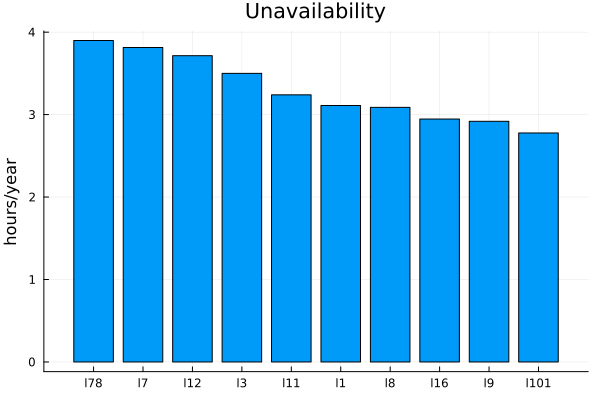

In [14]:
U_bar_e = sorted_bar_plot(res_agg.branch_agg, "U", 10, "Unavailability", "hours/year")

In [15]:
savefig(U_bar_e, "U_bar_e.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/U_bar_e.png"

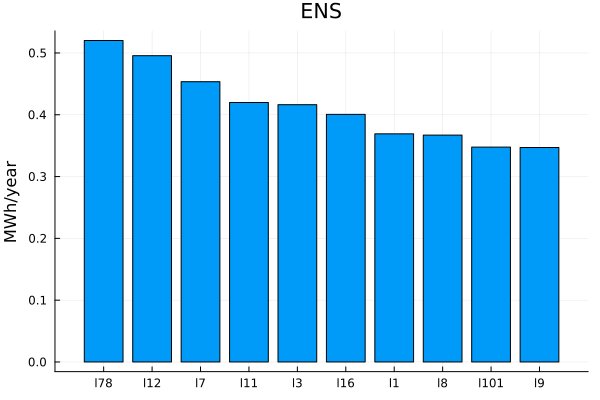

In [16]:
ENS_bar_e = sorted_bar_plot(res_agg.branch_agg, "ENS", 10, "ENS", "MWh/year")

In [17]:
savefig(ENS_bar_e, "ENS_bar_e.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/ENS_bar_e.png"

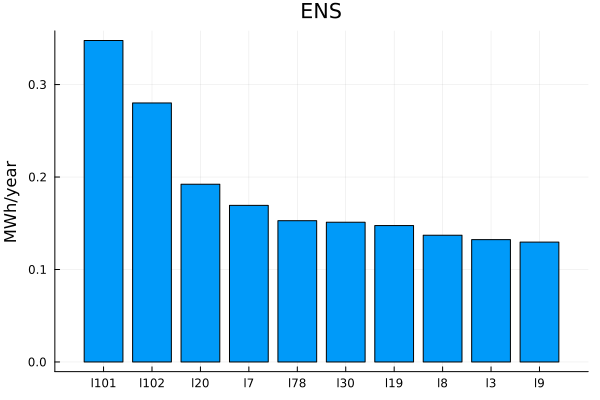

In [18]:
ENS_bar_e_62 = sorted_bar_plot(res_agg_62.branch_agg, "ENS", 10, "ENS", "MWh/year")

In [19]:
savefig(ENS_bar_e_62, "ENS_bar_e_62.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/ENS_bar_e_62.png"

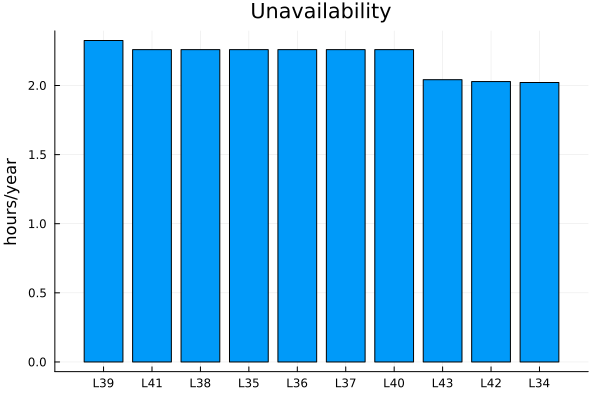

In [20]:
U_bar_l = sorted_bar_plot(res_agg.load_agg, "U", 10, "Unavailability", "hours/year")

In [21]:
savefig(U_bar_l, "U_bar_l.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/U_bar_l.png"

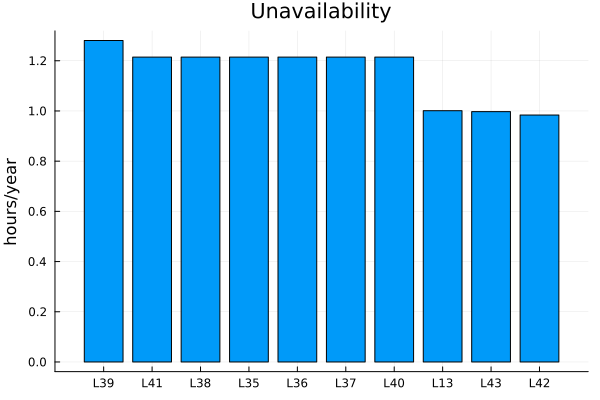

In [22]:
U_bar_l_62 = sorted_bar_plot(res_agg_62.load_agg, "U", 10, "Unavailability", "hours/year")

In [23]:
savefig(U_bar_l_62, "U_bar_l_62.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/U_bar_l_62.png"

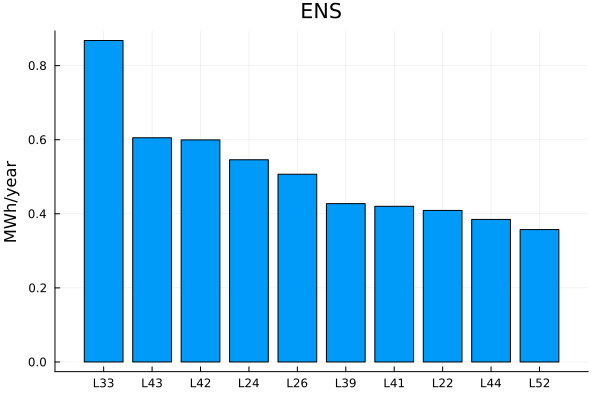

In [24]:
ENS_bar_l = sorted_bar_plot(res_agg.load_agg, "ENS", 10, "ENS", "MWh/year")

In [25]:
savefig(ENS_bar_l, "ENS_bar_l.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/ENS_bar_l.png"

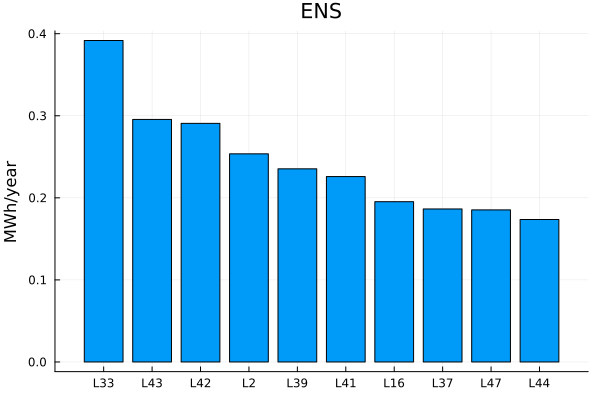

In [26]:
ENS_bar_l_62 = sorted_bar_plot(res_agg_62.load_agg, "ENS", 10, "ENS", "MWh/year")

In [27]:
savefig(ENS_bar_l_62, "ENS_bar_l_62.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/ENS_bar_l_62.png"

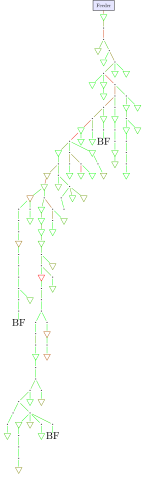

In [28]:
node_styles, node_labels = create_node_labels(network, res_agg.load_agg, :ENS)
edge_colors, edge_labels = create_edge_labels(network, res_agg.branch_agg, :ENS)
f=TikzGraphs.plot(DiGraph(network.radial), node_labels, node_styles=node_styles,
edge_style="-, green", edge_styles=edge_colors, options="scale=0.4")

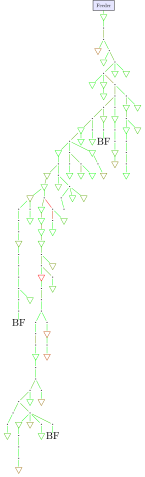

In [29]:
node_styles, node_labels = create_node_labels(network, res_agg_62.load_agg, :ENS)
edge_colors, edge_labels = create_edge_labels(network, res_agg_62.branch_agg, :ENS)
TikzGraphs.plot(DiGraph(network.radial), node_labels, node_styles=node_styles,
edge_style="-, green", edge_styles=edge_colors, options="scale=0.4")

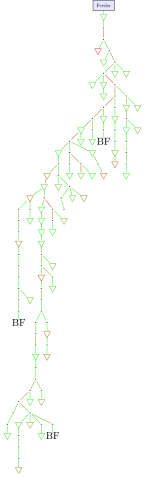

In [30]:
node_styles, node_labels = create_node_labels(network, res_agg_R.load_agg, :ENS)
edge_colors, edge_labels = create_edge_labels(network, res_agg_R.branch_agg, :ENS)
TikzGraphs.plot(DiGraph(network.radial), node_labels, node_styles=node_styles,
edge_style="-, green", edge_styles=edge_colors, options="scale=0.4")

In [31]:
ENS_62 = sum(res_62.ENS)

4.8170561508722685

In [32]:
ENS = sum(res.ENS)

9.636904149588787

In [33]:
ENS_R=sum(res_R.ENS)

3.7748164767134895

In [34]:
U=sum(res.U)

76.41613712636237

In [35]:
U_62=sum(res_62.U)

41.28486976575749

In [36]:
U_R=sum(res_R.U)

33.56391336191655

In [72]:
ENS/ENS_62

2.000579575524305

In [73]:
ENS_old_line/ENS_old_line_62

2.0880063267099733

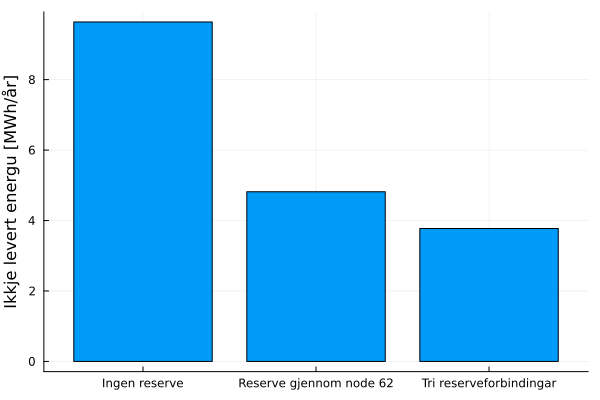

In [42]:
bar_ens_alt_r=bar([ENS, ENS_62, ENS_R] ,xticks=(1:3, ["Ingen reserve", "Reserve gjennom node 62", "Tri reserveforbindingar"]),
    ylabel="Ikkje levert energu [MWh/år]", legend=false)

In [43]:
savefig(bar_ens_alt_r, "ENS_r_alt.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/ENS_r_alt.png"

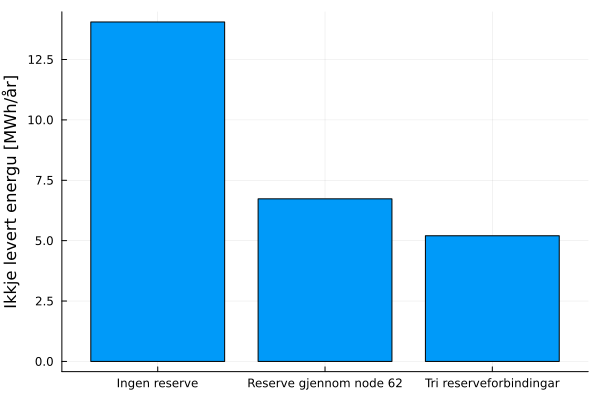

In [71]:
bar_ens_alt_r=bar([ENS_old_line, ENS_old_line_62, ENS_old_line_R] ,xticks=(1:3, ["Ingen reserve", "Reserve gjennom node 62", "Tri reserveforbindingar"]),
    ylabel="Ikkje levert energu [MWh/år]", legend=false)

In [80]:
savefig(bar_ens_alt_r, "ENS_old.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/ENS_old.png"

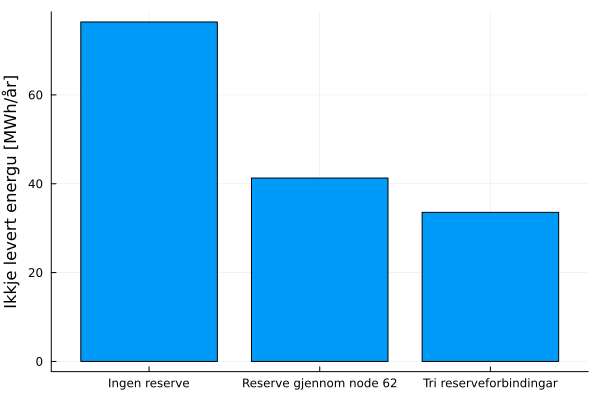

In [38]:
bar([U, U_62, U_R] ,xticks=(1:3, ["Ingen reserve", "Reserve gjennom node 62", "Tri reserveforbindingar"]),
    ylabel="Ikkje levert energu [MWh/år]", legend=false)

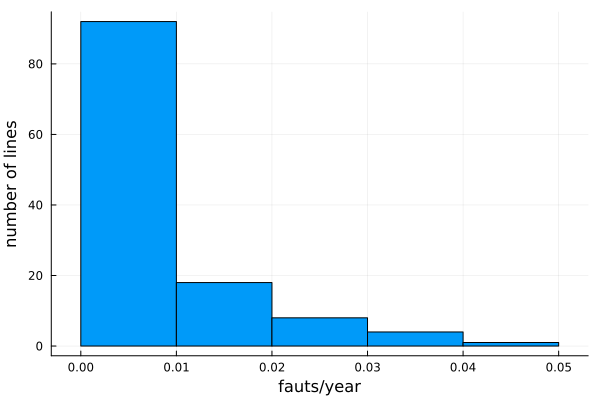

In [39]:
lambda = network.mpc.reldata.temporaryFaultFrequency
fault_hist = histogram(filter(!iszero, lambda), bins=:scott, legend=false,
ylabel="number of lines", xlabel="fauts/year")

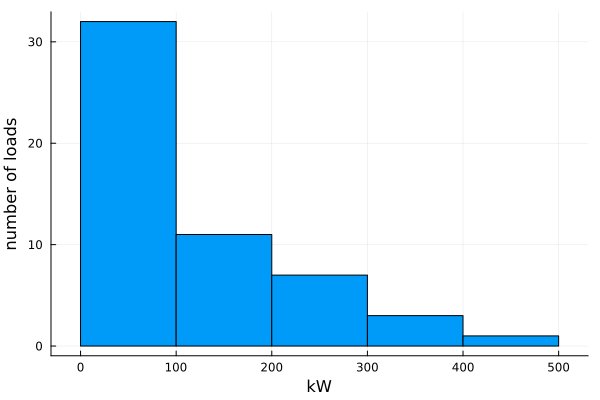

In [40]:
loads = network.mpc.bus.Pd*1000
load_hist = histogram(filter(!iszero, loads), bins=:scott, legend=false, ylabel="number of loads",
xlabel="kW")

In [41]:
savefig(fault_hist, "faults_hist.png")
savefig(load_hist, "load_hist.png")

"/home/sigurd/.julia/dev/RelDist.jl/examples/CINELDI/load_hist.png"